<a href="https://colab.research.google.com/github/Vishu-Gupta/MLProjects/blob/main/Gesture_Control/Conv3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Loading the data

In [36]:
# Install the PyDrive wrapper & import libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

KeyboardInterrupt: ignored

In [ ]:
!unzip Project_data.zip

In [ ]:
!mkdir Final_data/

In [ ]:
!mv Project_data/* Final_data/

In [ ]:
!rm -r Project_data
!rm Project_data.zip

In [16]:
!rm -r model_init*

In [17]:
!nvidia-smi

Wed May 18 12:13:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |   8897MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
#!pip install scipy==1.1.0 , used to install scipy 1.10 as imread has been deprecteated

In [19]:
import numpy as np
import os
from imageio import imread
import datetime
import os
from skimage.transform import resize as imresize

We set the random seed so that the results don't vary drastically.

In [20]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [21]:
train_doc = np.random.permutation(open('Final_data/train.csv').readlines())
val_doc = np.random.permutation(open('Final_data/val.csv').readlines())
batch_size = 60

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [22]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(10,30))#create a list of image numbers you want to use for a particular video # choosen 11 onwards
    x = len(img_idx) # no of images for each video
    y,z=120,160 # resized all images to 120,160
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    try:
                      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      
                      #crop the images and resize them. Note that the images are of 2 different shape 
                      #and the conv3D will throw error if the inputs in a batch have different shapes
                      resized_img = imresize(image,(y,z))
                      
                      batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255. #normalise and feed in the image
                      batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255. #normalise and feed in the image
                      batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255. #normalise and feed in the image
                      batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    except:
                      #print("Image Skipped")
                      continue
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remains = len(t) - num_batches*batch_size
        batch_data = np.zeros((remains,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((remains,5))
        for folder in range(remains):
          imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
          for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
              try:
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                resized_img = imresize(image,(y,z))
                
                batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255. #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255. #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255. #normalise and feed in the image
                
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
              except:
                #print("image skipped")
                continue
          yield batch_data, batch_labels 



        


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [23]:
curr_dt_time = datetime.datetime.now()
train_path = 'Final_data/train'
val_path = 'Final_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [24]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model = Sequential([
      Conv3D(8,(3,3,3),activation='relu',input_shape=(20,120,160,3)),
      MaxPooling3D((2,2,2)),
      Conv3D(16,(3,3,3),activation='relu'),
      MaxPooling3D((2,2,2)),
      Flatten(),
      Dense(128,activation='relu'),
      Dense(5,activation='softmax')
])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [25]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 18, 118, 158, 8)   656       
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 9, 59, 79, 8)     0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 7, 57, 77, 16)     3472      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 28, 38, 16)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 51072)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [26]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [27]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [28]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [29]:
"""model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)"""

'model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, \n                    callbacks=callbacks_list, validation_data=val_generator, \n                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)'

In [30]:
history = model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,validation_freq=1)

Source path =  Final_data/train ; batch size = 60
Epoch 1/5
11/12 [==========================>...] - ETA: 13s - loss: 3.4464 - categorical_accuracy: 0.2076Source path =  Final_data/val ; batch size = 60

Epoch 1: saving model to model_init_2022-05-1812_13_12.221223/model-00001-3.43076-0.20664-0.95540-0.17000.h5
12/12 [==============================] - 150s 14s/step - loss: 3.4308 - categorical_accuracy: 0.2066 - val_loss: 0.9554 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 1.5300 - categorical_accuracy: 0.2459 
Epoch 2: saving model to model_init_2022-05-1812_13_12.221223/model-00002-1.52997-0.24587-0.00000-0.00000.h5
12/12 [==============================] - 132s 12s/step - loss: 1.5300 - categorical_accuracy: 0.2459 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/5
12/12 [==============================] - ETA: 0s - loss: 1.3328 - categorical_accuracy: 0.4408
Epoch 3: saving model t

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


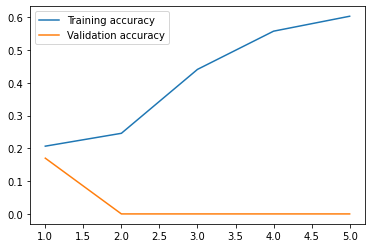

In [46]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
epochs = list(range(1,num_epochs+1))
plt.xticks=epochs
sns.lineplot(epochs,train_acc,label='Training accuracy')
sns.lineplot(epochs,val_acc,label='Validation accuracy')